In [1]:
import numpy as np
import neurokit2 as nk
from scipy import integrate
import pickle
import pandas as pd
import numpy as np
# acceleration
def acc(speed, time):
    return np.gradient(speed, time, edge_order=2)

# motion sickness dose value
def msdv_eq(speed, time):
    return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))

# peaks
def find_peaks(gsr):
    decomposed_eda = nk.eda_process(gsr, sampling_rate=4)[0]
    eda_interval = nk.eda_intervalrelated(decomposed_eda, sampling_rate=4)
    num_of_peaks = eda_interval["SCR_Peaks_N"]
    return sum(num_of_peaks)

# load data
data_path = './data/raw_data2020.p'
dataPoolfont_sizefont_size = pickle.load(open(data_path, "rb"))

num_of_samples = len(list(dataPoolfont_sizefont_size.keys()))
# num_of_samples = 1
num_of_interval = 30

figsize = (15, 10)

input_list = []
output_list = []

for j in range(num_of_samples):
    name = list(dataPoolfont_sizefont_size.keys())[j]
    one_sample = dataPoolfont_sizefont_size[name]
    time_speed = one_sample.Steam.rawSpeed.Time
    raw_speed = one_sample.Steam.rawSpeed.Speed
    GSR = one_sample.Empatica.GSR
    time_eda = one_sample.Empatica.GSR.Time
    one_sample_input = []
    one_sample_output = []
    
    # adjust time scale
    t = np.arange(0, 0.25*len(GSR), 0.25)
    t_difference = t[-1] - time_speed.iloc[-1]
    if t_difference >= 0:
        countTimeInZero = int(t_difference/0.25)
        timeBase = t[countTimeInZero]
        t -= timeBase
    GSR.E4_Time = t
    GSR = GSR.drop(GSR[GSR.E4_Time < 0].index)
    GSR.reset_index(drop=True, inplace=True)
    
    # Peaks
    # method = neurokit / biosppy
    decomposed_eda = nk.eda_process(GSR.GSR, sampling_rate=4)[0]
    step = int(len(GSR.GSR) / num_of_interval)
    peaks_list = []
    piece_gsr = []
    for i in range(0, len(GSR.GSR), step):
        if len(GSR.GSR[i: i+step]) < step:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i-step:], 
                                                  sampling_rate=4)
            peaks_list[-1] = eda_interval["SCR_Peaks_N"].values
            piece_gsr[-1] = decomposed_eda["EDA_Raw"][i-step:].values
            # piece_gsr[-1] = decomposed_eda["EDA_Phasic"][i-step:].values
        else:
            eda_interval = nk.eda_intervalrelated(decomposed_eda[i: i+step], 
                                                  sampling_rate=4)
            peaks_list.append(eda_interval["SCR_Peaks_N"].values)
            piece_gsr.append(decomposed_eda["EDA_Raw"][i: i+step].values)
            # piece_gsr.append(decomposed_eda["EDA_Phasic"][i: i+step].values)

    # MSDV
    msdv_list = []
    step = int(len(time_speed) / num_of_interval)
    speed_list = []
    for i in range(0, len(raw_speed), step):
        if len(raw_speed[i: i+step]) < step:
            speed_list[-1] = raw_speed[i-step:].values
            msdv_list[-1] = msdv_eq(raw_speed[i-step:], time_speed[i-step:])
        else:
            speed_list.append(raw_speed[i: i+step].values)
            msdv_list.append(msdv_eq(raw_speed[i: i+step], time_speed[i: i+step]))
    
    input_list.append([name, speed_list, piece_gsr]) # INPUT
    output_list.append([name, msdv_list, peaks_list]) # OUTPUT

merged_input_list = []
merged_output_list = []
for i in range(num_of_samples):
    # remove group name
    input_list[i][0] = input_list[i][0].split("group")[0]
    input_list[i][0] = input_list[i][0].split("gift")[0]
    output_list[i][0] = output_list[i][0].split("group")[0]
    output_list[i][0] = output_list[i][0].split("gift")[0]
# merge info
skip_step, pivot = 0, 0
for i in range(num_of_samples):
    name = input_list[pivot][0]
    tmp_speed = input_list[pivot][1]
    tmp_gsr = input_list[pivot][2]
    tmp_msdv = output_list[pivot][1]
    tmp_peaks = output_list[pivot][2]
    matched = False
    for j in range(pivot+1, num_of_samples, 1):
        if name == input_list[j][0]:
            tmp_speed = tmp_speed + input_list[j][1]
            tmp_gsr = tmp_gsr + input_list[j][2]
            tmp_msdv = tmp_msdv + output_list[j][1]
            tmp_peaks = tmp_peaks + output_list[j][2]
            skip_step = j
            matched = True
    merged_input_list.append([name, tmp_speed, tmp_gsr])
    merged_output_list.append([name, tmp_msdv, tmp_peaks])
    if matched:
        pivot = skip_step+1
    else:
        pivot += 1
    if pivot >= num_of_samples:
        break

# file_name = './peaks/data0_BingHan4.txt'
# with open(file_name, 'wb') as fp:
#     pickle.dump(merged_output_list[4][2], fp)

file_name = 'input.txt'
with open(file_name, 'wb') as fp:
    pickle.dump(merged_input_list, fp)

# 120 trails: 'BingHan'4, 'Cunbo'7, 'Guanzhi'12, 'Lingfeng'26, 'Minghui'31, 'Olaf'32,
#                'Qichen'34, 'Wenzhe'40, 'Xinrui'43, 'Zhilong'51, 'Zihan'52

index = 52
action, msdv, sickness_level = [], [], []
# bound = [speed, msdv, sickness_level(1), sickness_level(2), sickness_level(3)]
bound = [1, 0.8, 0.1, 2.5, 4]
for i in range(120):
    # speed <=> action
    if np.mean(merged_input_list[index][1][i]) < bound[0]:
        action.append(0)
    else:
        action.append(1)
    # msdv <=> reward 
    if np.mean(merged_output_list[index][1][i]) < bound[1]:
        msdv.append(0)
    else:
        msdv.append(1)
    # true sickness level
    average = np.mean(merged_input_list[index][2][i])
    if average <= bound[2]:
        sickness_level.append(0.1)
    elif bound[2] < average <= bound[3]:
        sickness_level.append(0.4)
    elif bound[3] < average <= bound[4]:
        sickness_level.append(0.6)
    else:
        sickness_level.append(0.9)
    
action = np.double(action)
msdv = np.double(msdv)
# save as .mat file
import scipy     
Data = {'action': action, 'reward': msdv}
scipy.io.savemat('Data.mat', Data_0, oned_as='column')
Data = {"level": sickness_level}
scipy.io.savemat("Sickness_level.mat", Data, oned_as='row')




/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_intervalrelated.py:116: RuntimeWarning: Mean of empty slice
  output["SCR_Peaks_Amplitude_Mean"] = np.nanmean(data[peaks_idx]["SCR_Amplitude"].values)
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_334/1391555426.py:13: DeprecationWarning: 'scipy.integrate.cumtrapz' is deprecated in favour of 'scipy.integrate.cumulative_trapezoid' and will be removed in SciPy 1.14.0
  return np.sqrt(integrate.cumtrapz(acc(speed, time)**2, time, initial=0))
/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/neurokit2/eda/eda_clean.py:105: NeuroKitWarning: EDA signal is sampled at very low frequency. Skipping filtering.
  warn(
/var/folders/gk/z87t1wqx4p300dbsfbpqs4tw0000gn/T/ipykernel_334/1391555426.py:13: Deprec

NameError: name 'Data_0' is not defined

In [2]:
df_input = pd.DataFrame(merged_input_list,columns=['Participant', 'Speed', 'GSR'])
new_df = df_input
new_df

,Participant,Speed,GSR
0,Andreas,"[[0.0, 1.408541, 1.405054, 1.40149, 1.399373, ...","[[2.327969, 2.362554, 2.41123, 2.466311, 2.527..."
1,Anjela,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[1.286659, 1.295627, 1.296908, 1.295627, 1.30..."
2,Anne,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.4264778, 0.4290392, 0.4277585, 0.4277585, ..."
3,Aron,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.2536119, 0.2536119, 0.2548928, 0.252331, 0..."
4,BingHan,"[[0.0, 0.4219726, 0.4100565, 0.4061294, 0.4035...","[[4.417199, 4.447938, 4.492765, 4.518382, 4.52..."
5,Bowen,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.1191279, 0.1178469, 0.1204088, 0.1191279, ..."
6,Chenyang,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[5.803594, 5.783101, 5.820244, 5.859949, 5.91..."
7,Cunbo,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.3537439, 0.3511825, 0.3499017, 0.3499017, ..."
8,Danfo,"[[0.0, 0.8736041, 0.8729813, 0.8732041, 0.8738...","[[0.3691569, 0.3627525, 0.3653143, 0.3307308, ..."
9,Emilio,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.2267, 0.2279808, 0.2279808, 0.2254192, 0.2..."


In [3]:
# df_output = pd.DataFrame(merged_output_list,columns=['Participant', 'tmp_msdv', 'peaks'])
# new_df = df_output
# new_df

In [4]:
import pandas as pd
import numpy as np

# 选择一个参与者的数据，例如Andreas
participant_data = new_df[new_df['Participant'] == 'Andreas']


# mean_speed = [np.mean(group) for group in participant_data['tmp_msdv'].values[0]]
# mean_gsr = [np.mean(group) for group in participant_data['peaks'].values[0]]


mean_speed = [np.mean(group) for group in participant_data['Speed'].values[0]]
mean_gsr = [np.mean(group) for group in participant_data['GSR'].values[0]]


# 创建一个新的DataFrame
ddf = pd.DataFrame({
    'Mean Speed': mean_speed,
    'Mean GSR': mean_gsr
})

ddf

,Mean Speed,Mean GSR
0,1.341035,2.429684
1,1.292783,2.470197
2,1.287352,2.812556
3,1.316790,2.905305
4,1.353730,2.992169
...,...,...
85,2.126096,0.967875
86,2.143543,0.948785
87,2.309100,0.968476
88,2.248177,1.162784


In [5]:
all_data = []

# 对于每一个参与者，计算他们的速度和GSR均值
for participant in new_df['Participant'].unique():
    participant_data = new_df[new_df['Participant'] == participant]
    
    mean_speed = [np.mean(group) for group in participant_data['Speed'].values[0]]
    mean_gsr = [np.mean(group) for group in participant_data['GSR'].values[0]]
    
    # 将参与者的结果添加到列表中
    for i in range(len(mean_speed)):
        all_data.append({
            'Participant': participant,
            'Mean Speed': mean_speed[i],
            'Mean GSR': mean_gsr[i]
        })

# DataFrame
ddf = pd.DataFrame(all_data)
ddf

,Participant,Mean Speed,Mean GSR
0,Andreas,1.341035,2.429684
1,Andreas,1.292783,2.470197
2,Andreas,1.287352,2.812556
3,Andreas,1.316790,2.905305
4,Andreas,1.353730,2.992169
...,...,...,...
4765,Zunchao,2.158964,4.807752
4766,Zunchao,2.341897,4.848170
4767,Zunchao,2.325927,5.020405
4768,Zunchao,2.275807,5.216416


In [6]:
# def compute_contrast(data):
#     mean_intensity = np.mean(data)
#     contrast = (data - mean_intensity) / mean_intensity
#     return contrast

# ddf['Speed Contrast'] = compute_contrast(ddf['Mean Speed'])
# ddf['GSR Contrast'] = compute_contrast(ddf['Mean GSR'])

# # 计算累积概率分布函数（CDF）
# speed_cdf = np.cumsum(np.histogram(ddf['Speed Contrast'], bins=100, density=True)[0])
# gsr_cdf = np.cumsum(np.histogram(ddf['GSR Contrast'], bins=100, density=True)[0])

# # 绘制对比水平和累积概率分布
# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.plot(np.linspace(0, 1, len(speed_cdf)), speed_cdf, label='Speed CDF')
# plt.xlabel('Speed Contrast')
# plt.ylabel('Cumulative Probability')
# plt.title('Speed Contrast CDF')
# plt.legend()

# # plt.subplot(1, 2, 2)
# # plt.plot(np.linspace(0, 1, len(gsr_cdf)), gsr_cdf, label='GSR CDF', color='r')
# # plt.xlabel('GSR Contrast')
# # plt.ylabel('Cumulative Probability')
# # plt.title('GSR Contrast CDF')
# # plt.legend()

# # plt.tight_layout()
# plt.show()


In [7]:

# import pandas as pd
# import numpy as np

# # 选择一个参与者的数据，例如Andreas
# participant_data = new_df[new_df['Participant'] == 'Andreas']


# # mean_speed = [np.mean(group) for group in participant_data['tmp_msdv'].values[0]]
# # mean_gsr = [np.mean(group) for group in participant_data['peaks'].values[0]]


# mean_speed = [np.mean(group) for group in participant_data['Speed'].values[0]]
# mean_gsr = [np.mean(group) for group in participant_data['GSR'].values[0]]


# # 创建一个新的DataFrame
# ddf = pd.DataFrame({
#     'Mean Speed': mean_speed,
#     'Mean GSR': mean_gsr
# })

# ddf


# def compute_contrast(data):
#     mean_intensity = np.mean(data)
#     contrast = (data - mean_intensity) / mean_intensity
#     return contrast

# ddf['Speed Contrast'] = compute_contrast(ddf['Mean Speed'])
# ddf['GSR Contrast'] = compute_contrast(ddf['Mean GSR'])

# # 计算累积概率分布函数（CDF）
# speed_cdf = np.cumsum(np.histogram(ddf['Speed Contrast'], bins=100, density=True)[0])
# gsr_cdf = np.cumsum(np.histogram(ddf['GSR Contrast'], bins=100, density=True)[0])


# plt.figure(figsize=(8, 6))
    
# # 绘制单个参与者的黑色点
# plt.scatter(participant_speed_contrast, participant_gsr_response, label=f'{participant_id} Data', color='black')

# # 绘制CDF曲线
# x = np.linspace(min(all_speed_contrast), max(all_speed_contrast), 100)
# plt.plot(x, sigmoid(x, *popt), label='Cumulative Probability')

# plt.xlabel('Contrast ($\Delta I / \overline{I}$)')
# plt.ylabel('Response')
# plt.title(f'Contrast-Response Function and CDF for {participant_id}')
# plt.legend()

In [8]:
ddf['Participant']

0       Andreas
1       Andreas
2       Andreas
3       Andreas
4       Andreas
         ...   
4765    Zunchao
4766    Zunchao
4767    Zunchao
4768    Zunchao
4769    Zunchao
Name: Participant, Length: 4770, dtype: object

In [9]:
# choose one participent
participant_id = 'Ramon'  
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

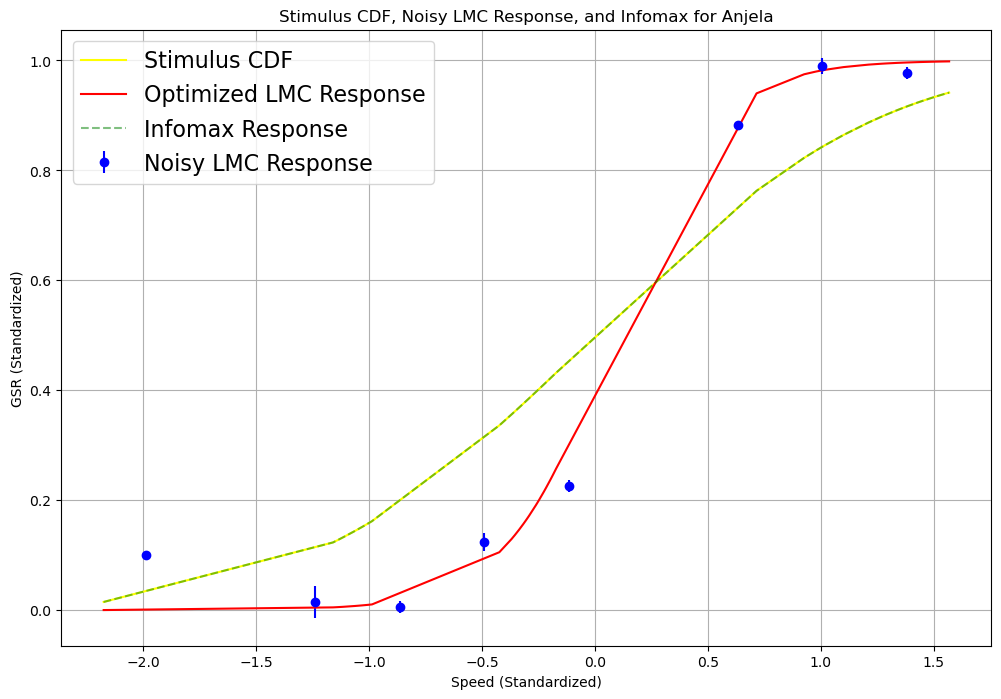

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# 假设你的数据已经以DataFrame的形式加载到ddf变量中

# Choose one participant
participant_id = 'Anjela'  
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

# Step 1: Standardize the data
x = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
y = (participant_gsr_response - np.mean(participant_gsr_response)) / np.std(participant_gsr_response)

# Sort the data to ensure clean plotting
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Step 2: Compute the stimulus CDF
stimulus_cdf = norm.cdf(x, loc=np.mean(x), scale=np.std(x))

# Step 3: Compute LMC response and add noise
def true_nonlinearity(x):
    return 0.5 * (1 + np.tanh(3 * x))

# Add Gaussian noise
noise_level = 0.05
lmc_response = true_nonlinearity(x) + np.random.normal(0, noise_level, size=x.shape)

# Step 4: Divide data into 10 intervals and calculate means and error bars
intervals = np.linspace(np.min(x), np.max(x), 11)
means = []
errors = []
interval_centers = []

for i in range(len(intervals) - 1):
    idx = (x >= intervals[i]) & (x < intervals[i + 1])
    if np.sum(idx) > 0:  # Ensure there's data in the interval
        mean_value = np.mean(lmc_response[idx])
        error_value = np.std(lmc_response[idx]) / np.sqrt(np.sum(idx))
        means.append(mean_value)
        errors.append(error_value)
        interval_centers.append((intervals[i] + intervals[i + 1]) / 2)

# Step 5: Define the loss function for Bayesian Efficient Coding (MSE-based)
def loss_function(params, x, y, p):
    g_x = 0.5 * (1 + np.tanh(params[0] * x + params[1]))
    y_hat = g_x
    return np.sum(np.abs(y - y_hat) ** p)

# Step 6: Optimize the nonlinearity parameter using a specific loss function
p = 2  # Using mean squared error (MSE)
result = minimize(loss_function, x0=[3, 0], args=(x, lmc_response, p), method='Nelder-Mead')
optimized_params = result.x

# Generate the optimized LMC response
optimized_response = 0.5 * (1 + np.tanh(optimized_params[0] * x + optimized_params[1]))

# Step 7: Compute the Infomax response (maximize mutual information)
infomax_response = stimulus_cdf

# Step 8: Plot the results
plt.figure(figsize=(12, 8))

# Plot the stimulus CDF as a solid line
plt.plot(x, stimulus_cdf, label="Stimulus CDF", color='yellow', linestyle='-')

# Plot the noisy LMC response as points with error bars
plt.errorbar(interval_centers, means, yerr=errors, fmt='o', color='blue', label="Noisy LMC Response")

# Plot the optimized LMC response from BEC
plt.plot(x, optimized_response, label="Optimized LMC Response", color='red', linestyle='-')

# Plot the Infomax response as a transparent dashed gray line
plt.plot(x, infomax_response, label="Infomax Response", color='green', linestyle='--', alpha=0.5)

plt.xlabel("Speed (Standardized)")
plt.ylabel("GSR (Standardized)")
plt.title(f"Stimulus CDF, Noisy LMC Response, and Infomax for {participant_id}")
plt.legend(fontsize=16)
plt.grid(True)
plt.show()


In [47]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# 确保 BEC_result 文件夹存在
output_dir = "BEC_result"
os.makedirs(output_dir, exist_ok=True)

# 假设数据已经加载到 ddf 变量中
# ddf = pd.read_csv("your_data.csv")

# 定义颜色映射
colors = {0.5: 'red', 1: 'blue', 2: 'green'}

# 仅针对特定参与者 Anjela 执行实验
participant_id = 'Anjela'
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

# Step 1: Standardize the data
x = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
y = (participant_gsr_response - np.mean(participant_gsr_response)) / np.std(participant_gsr_response)

# Sort the data to ensure clean plotting
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Step 2: Compute the stimulus CDF
stimulus_cdf = norm.cdf(x, loc=np.mean(x), scale=np.std(x))

# Step 3: Compute LMC response and add noise
def true_nonlinearity(x):
    return 0.5 * (1 + np.tanh(3 * x))

# Add Gaussian noise
noise_level = 0.05
lmc_response = true_nonlinearity(x) + np.random.normal(0, noise_level, size=x.shape)

# Step 4: Divide data into 10 intervals and calculate means and error bars
intervals = np.linspace(np.min(x), np.max(x), 11)
means = []
errors = []
interval_centers = []

for i in range(len(intervals) - 1):
    idx = (x >= intervals[i]) & (x < intervals[i + 1])
    if np.sum(idx) > 0:  # Ensure there's data in the interval
        mean_value = np.mean(lmc_response[idx])
        error_value = np.std(lmc_response[idx]) / np.sqrt(np.sum(idx))
        means.append(mean_value)
        errors.append(error_value)
        interval_centers.append((intervals[i] + intervals[i + 1]) / 2)

# Step 5: Define the loss function for Bayesian Efficient Coding (MSE-based)
def loss_function(params, x, y, p):
    g_x = 0.5 * (1 + np.tanh(params[0] * x + params[1]))
    y_hat = g_x
    return np.sum(np.abs(y - y_hat) ** p)

# Step 6: Plot the results for different p values and compute MSE
plt.figure(figsize=(12, 8))

# Plot the stimulus CDF as a solid line
plt.plot(x, stimulus_cdf, label="Stimulus CDF", color='yellow', linestyle='-')

# Plot the noisy LMC response as points with error bars
plt.errorbar(interval_centers, means, yerr=errors, fmt='o', color='blue', label="Noisy LMC Response")

# Iterate over different p values and plot the results
for p_value in [0.5, 1, 2]:
    result = minimize(loss_function, x0=[3, 0], args=(x, lmc_response, p_value), method='Nelder-Mead')
    optimized_params = result.x

    # Generate the optimized LMC response
    optimized_response = 0.5 * (1 + np.tanh(optimized_params[0] * x + optimized_params[1]))

    # Calculate MSE
    mse = np.mean((lmc_response - optimized_response) ** 2)
    print(f"MSE for p={p_value}: {mse}")

    # Plot the optimized LMC response with different colors for different p values
    plt.plot(x, optimized_response, label=f"Optimized LMC Response (p={p_value}, MSE={mse:.4f})", color=colors[p_value], linestyle='-')

# Plot the Infomax response as a transparent dashed gray line
plt.plot(x, stimulus_cdf, label="Infomax Response", color='green', linestyle='--', alpha=0.5)

plt.xlabel("Speed (Standardized)")
plt.ylabel("GSR (Standardized)")
plt.title(f"Stimulus CDF, Noisy LMC Response, and BEC for {participant_id}")
plt.legend(fontsize=16)
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(output_dir, f"{participant_id}FMC.png"))
plt.close()


MSE for p=0.5: 0.0021114544625033664
MSE for p=1: 0.002089238799598232
MSE for p=2: 0.002086872659900843


In [32]:
# BEC with Fitness Maximizing Code Loss

In [48]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# 确保 BEC_result 文件夹存在
output_dir = "BEC_result"
os.makedirs(output_dir, exist_ok=True)

# 假设数据已经加载到 ddf 变量中
# ddf = pd.read_csv("your_data.csv")

# 定义颜色映射
colors = {0.5: 'red', 1: 'blue', 2: 'green'}

# 仅针对特定参与者 Anjela 执行实验
participant_id = 'Anjela'
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

# Step 1: Standardize the data
x = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
y = (participant_gsr_response - np.mean(participant_gsr_response)) / np.std(participant_gsr_response)

# Sort the data to ensure clean plotting
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Step 2: Compute the stimulus CDF
stimulus_cdf = norm.cdf(x, loc=np.mean(x), scale=np.std(x))

# Step 3: Compute LMC response and add noise
def true_nonlinearity(x):
    return 0.5 * (1 + np.tanh(3 * x))

# Add Gaussian noise
noise_level = 0.05
lmc_response = true_nonlinearity(x) + np.random.normal(0, noise_level, size=x.shape)

# Step 4: Divide data into 10 intervals and calculate means and error bars
intervals = np.linspace(np.min(x), np.max(x), 11)
means = []
errors = []
interval_centers = []

for i in range(len(intervals) - 1):
    idx = (x >= intervals[i]) & (x < intervals[i + 1])
    if np.sum(idx) > 0:  # Ensure there's data in the interval
        mean_value = np.mean(lmc_response[idx])
        error_value = np.std(lmc_response[idx]) / np.sqrt(np.sum(idx))
        means.append(mean_value)
        errors.append(error_value)
        interval_centers.append((intervals[i] + intervals[i + 1]) / 2)

# Step 5: Define the FMC loss function
def fmc_loss_function(params, x, y):
    g_x = 0.5 * (1 + np.tanh(params[0] * x + params[1]))
    weights = np.abs(y)  # Assuming the weight function w(y) is the absolute value of y
    loss = np.sum(weights * (y - g_x) ** 2)
    return loss

# Step 6: Plot the results for different p values and compute MSE
plt.figure(figsize=(12, 8))

# Plot the stimulus CDF as a solid line
plt.plot(x, stimulus_cdf, label="Stimulus CDF", color='yellow', linestyle='-')

# Plot the noisy LMC response as points with error bars
plt.errorbar(interval_centers, means, yerr=errors, fmt='o', color='blue', label="Noisy LMC Response")

# Iterate over different p values and plot the results
for p_value in [0.5, 1, 2]:
    result = minimize(fmc_loss_function, x0=[3, 0], args=(x, lmc_response), method='Nelder-Mead')
    optimized_params = result.x

    # Generate the optimized LMC response
    optimized_response = 0.5 * (1 + np.tanh(optimized_params[0] * x + optimized_params[1]))

    # Calculate MSE
    mse = np.mean((lmc_response - optimized_response) ** 2)
    print(f"MSE for p={p_value}: {mse}")

    # Plot the optimized LMC response with different colors for different p values
    plt.plot(x, optimized_response, label=f"Optimized LMC Response (p={p_value}, MSE={mse:.4f})", color=colors[p_value], linestyle='-')

# Plot the Infomax response as a transparent dashed gray line
plt.plot(x, stimulus_cdf, label="Infomax Response", color='green', linestyle='--', alpha=0.5)

plt.xlabel("Speed (Standardized)")
plt.ylabel("GSR (Standardized)")
plt.title(f"Stimulus CDF, Noisy LMC Response, and FMC for {participant_id}")
plt.legend(fontsize=16)
plt.grid(True)

# Save the plot
plt.savefig(os.path.join(output_dir, f"{participant_id}FMC.png"))
plt.close()


MSE for p=0.5: 0.002446907509651278
MSE for p=1: 0.002446907509651278
MSE for p=2: 0.002446907509651278


In [25]:
# import os
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from scipy.optimize import minimize
# from scipy.stats import norm

# # 确保 BEC_result 文件夹存在
# output_dir = "BEC_result"
# os.makedirs(output_dir, exist_ok=True)

# # 假设数据已经加载到 ddf 变量中
# # ddf = pd.read_csv("your_data.csv")

# # 获取所有参与者的名称
# participants = ddf['Participant'].unique()

# # 对每个参与者执行实验
# for participant_id in participants:
#     participant_data = ddf[ddf['Participant'] == participant_id]
#     participant_speed_contrast = participant_data['Mean Speed'].values
#     participant_gsr_response = participant_data['Mean GSR'].values

#     # Step 1: Standardize the data
#     x = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
#     y = (participant_gsr_response - np.mean(participant_gsr_response)) / np.std(participant_gsr_response)

#     # Sort the data to ensure clean plotting
#     sorted_indices = np.argsort(x)
#     x = x[sorted_indices]
#     y = y[sorted_indices]

#     # Step 2: Compute the stimulus CDF
#     stimulus_cdf = norm.cdf(x, loc=np.mean(x), scale=np.std(x))

#     # Step 3: Compute LMC response and add noise
#     def true_nonlinearity(x):
#         return 0.5 * (1 + np.tanh(3 * x))

#     # Add Gaussian noise
#     noise_level = 0.05
#     lmc_response = true_nonlinearity(x) + np.random.normal(0, noise_level, size=x.shape)

#     # Step 4: Divide data into 10 intervals and calculate means and error bars
#     intervals = np.linspace(np.min(x), np.max(x), 11)
#     means = []
#     errors = []
#     interval_centers = []

#     for i in range(len(intervals) - 1):
#         idx = (x >= intervals[i]) & (x < intervals[i + 1])
#         if np.sum(idx) > 0:  # Ensure there's data in the interval
#             mean_value = np.mean(lmc_response[idx])
#             error_value = np.std(lmc_response[idx]) / np.sqrt(np.sum(idx))
#             means.append(mean_value)
#             errors.append(error_value)
#             interval_centers.append((intervals[i] + intervals[i + 1]) / 2)

#     # Step 5: Define the loss function for Bayesian Efficient Coding (MSE-based)
#     def loss_function(params, x, y, p):
#         g_x = 0.5 * (1 + np.tanh(params[0] * x + params[1]))
#         y_hat = g_x
#         return np.sum(np.abs(y - y_hat) ** p)

#     # Step 6: Optimize the nonlinearity parameter using a specific loss function
#     p = 2  # Using mean squared error (MSE)
#     result = minimize(loss_function, x0=[3, 0], args=(x, lmc_response, p), method='Nelder-Mead')
#     optimized_params = result.x

#     # Generate the optimized LMC response
#     optimized_response = 0.5 * (1 + np.tanh(optimized_params[0] * x + optimized_params[1]))

#     # Step 7: Compute the Infomax response (maximize mutual information)
#     infomax_response = stimulus_cdf

#     # Step 8: Plot the results
#     plt.figure(figsize=(12, 8))

#     # Plot the stimulus CDF as a solid line
#     plt.plot(x, stimulus_cdf, label="Stimulus CDF", color='yellow', linestyle='-')

#     # Plot the noisy LMC response as points with error bars
#     plt.errorbar(interval_centers, means, yerr=errors, fmt='o', color='blue', label="Noisy LMC Response")

#     # Plot the optimized LMC response from BEC
#     plt.plot(x, optimized_response, label="Optimized LMC Response", color='red', linestyle='-')

#     # Plot the Infomax response as a transparent dashed gray line
#     plt.plot(x, infomax_response, label="Infomax Response", color='green', linestyle='--', alpha=0.5)

#     plt.xlabel("Speed (Standardized)")
#     plt.ylabel("GSR (Standardized)")
#     plt.title(f"Stimulus CDF, Noisy LMC Response, and Infomax for {participant_id}")
#     plt.legend()
#     plt.grid(True)

#     # Save the plot
#     plt.savefig(os.path.join(output_dir, f"{participant_id}.png"))
#     plt.close()

# print(f"All participant plots have been saved to the '{output_dir}' folder.")


In [12]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# 确保 BEC_result 文件夹存在
output_dir = "BEC_result"
os.makedirs(output_dir, exist_ok=True)

# 假设数据已经加载到 ddf 变量中
# ddf = pd.read_csv("your_data.csv")

# 获取所有参与者的名称
participants = ddf['Participant'].unique()

# 定义颜色映射
colors = {0.5: 'red', 1: 'blue', 2: 'green'}

# 对每个参与者执行实验
for participant_id in participants:
    participant_data = ddf[ddf['Participant'] == participant_id]
    participant_speed_contrast = participant_data['Mean Speed'].values
    participant_gsr_response = participant_data['Mean GSR'].values

    # Step 1: Standardize the data
    x = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
    y = (participant_gsr_response - np.mean(participant_gsr_response)) / np.std(participant_gsr_response)

    # Sort the data to ensure clean plotting
    sorted_indices = np.argsort(x)
    x = x[sorted_indices]
    y = y[sorted_indices]

    # Step 2: Compute the stimulus CDF
    stimulus_cdf = norm.cdf(x, loc=np.mean(x), scale=np.std(x))

    # Step 3: Compute LMC response and add noise
    def true_nonlinearity(x):
        return 0.5 * (1 + np.tanh(3 * x))

    # Add Gaussian noise
    noise_level = 0.05
    lmc_response = true_nonlinearity(x) + np.random.normal(0, noise_level, size=x.shape)

    # Step 4: Divide data into 10 intervals and calculate means and error bars
    intervals = np.linspace(np.min(x), np.max(x), 11)
    means = []
    errors = []
    interval_centers = []

    for i in range(len(intervals) - 1):
        idx = (x >= intervals[i]) & (x < intervals[i + 1])
        if np.sum(idx) > 0:  # Ensure there's data in the interval
            mean_value = np.mean(lmc_response[idx])
            error_value = np.std(lmc_response[idx]) / np.sqrt(np.sum(idx))
            means.append(mean_value)
            errors.append(error_value)
            interval_centers.append((intervals[i] + intervals[i + 1]) / 2)

    # Step 5: Define the loss function for Bayesian Efficient Coding (MSE-based)
    def loss_function(params, x, y, p):
        g_x = 0.5 * (1 + np.tanh(params[0] * x + params[1]))
        y_hat = g_x
        return np.sum(np.abs(y - y_hat) ** p)

    # Step 6: Plot the results for different p values
    plt.figure(figsize=(12, 8))

    # Plot the stimulus CDF as a solid line
    plt.plot(x, stimulus_cdf, label="Stimulus CDF", color='yellow', linestyle='-')

    # Plot the noisy LMC response as points with error bars
    plt.errorbar(interval_centers, means, yerr=errors, fmt='o', color='blue', label="Noisy LMC Response")

    # Iterate over different p values and plot the results
    for p_value in [0.5, 1, 2]:
        result = minimize(loss_function, x0=[3, 0], args=(x, lmc_response, p_value), method='Nelder-Mead')
        optimized_params = result.x

        # Generate the optimized LMC response
        optimized_response = 0.5 * (1 + np.tanh(optimized_params[0] * x + optimized_params[1]))

        # Plot the optimized LMC response with different colors for different p values
        plt.plot(x, optimized_response, label=f"Optimized LMC Response (p={p_value})", color=colors[p_value], linestyle='-')

    # Plot the Infomax response as a transparent dashed gray line
    plt.plot(x, stimulus_cdf, label="Infomax Response", color='green', linestyle='--', alpha=0.5)

    plt.xlabel("Speed (Standardized)")
    plt.ylabel("GSR (Standardized)")
    plt.title(f"Stimulus CDF, Noisy LMC Response, and BEC for {participant_id}")
    plt.legend(fontsize=16)
    plt.grid(True)

    # Save the plot
    plt.savefig(os.path.join(output_dir, f"{participant_id}.png"))
    plt.close()

print(f"All participant plots with different p values have been saved to the '{output_dir}' folder.")


All participant plots with different p values have been saved to the 'BEC_result' folder.


## Linear-Nonlinear-Poisson (LNP) 

/Users/davidzhan/anaconda3/envs/ML1/lib/python3.11/site-packages/scipy/optimize/_optimize.py:941: RuntimeWarning: invalid value encountered in subtract
  np.max(np.abs(fsim[0] - fsim[1:])) <= fatol):


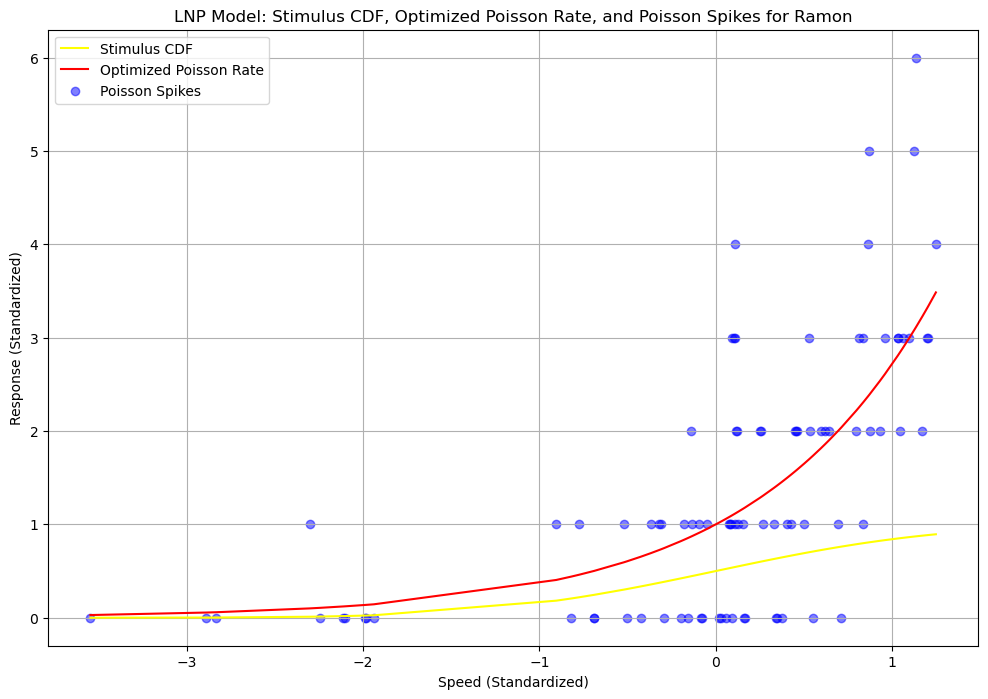

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, poisson

# 假设数据已经加载到 ddf 变量中

# Choose one participant
participant_id = 'Ramon'  
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

# Step 1: Standardize the data
x = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
y = (participant_gsr_response - np.mean(participant_gsr_response)) / np.std(participant_gsr_response)

# Sort the data to ensure clean plotting
sorted_indices = np.argsort(x)
x = x[sorted_indices]
y = y[sorted_indices]

# Step 2: Compute the stimulus CDF
stimulus_cdf = norm.cdf(x, loc=np.mean(x), scale=np.std(x))

# Step 3: Define the linear filter (for simplicity, assume identity)
def linear_filter(x):
    return x  # Here, the linear filter is simply the identity function

# Apply the linear filter to the stimulus
filtered_stimulus = linear_filter(x)

# Step 4: Define the nonlinear function and Poisson likelihood
def nonlinearity(params, x):
    return np.exp(params[0] * x + params[1])  # Exponential nonlinearity for Poisson rate

def poisson_loss(params, x, y):
    rate = nonlinearity(params, x)
    return -np.sum(poisson.logpmf(y, rate))  # Negative log-likelihood for Poisson spiking

# Step 5: Optimize the nonlinear function parameters
result = minimize(poisson_loss, x0=[1, 0], args=(filtered_stimulus, y), method='Nelder-Mead')
optimized_params = result.x

# Generate the optimized Poisson firing rate
optimized_rate = nonlinearity(optimized_params, filtered_stimulus)

# Step 6: Generate noisy Poisson spikes based on the optimized rate
poisson_spikes = poisson.rvs(optimized_rate)

# Step 7: Plot the results
plt.figure(figsize=(12, 8))

# Plot the stimulus CDF as a solid line
plt.plot(x, stimulus_cdf, label="Stimulus CDF", color='yellow', linestyle='-')

# Plot the Poisson spike rate as a line
plt.plot(x, optimized_rate, label="Optimized Poisson Rate", color='red', linestyle='-')

# Plot the noisy Poisson spikes as points
plt.scatter(x, poisson_spikes, color='blue', label="Poisson Spikes", alpha=0.5)

plt.xlabel("Speed (Standardized)")
plt.ylabel("Response (Standardized)")
plt.title(f"LNP Model: Stimulus CDF, Optimized Poisson Rate, and Poisson Spikes for {participant_id}")
plt.legend()
plt.grid(True)
plt.show()


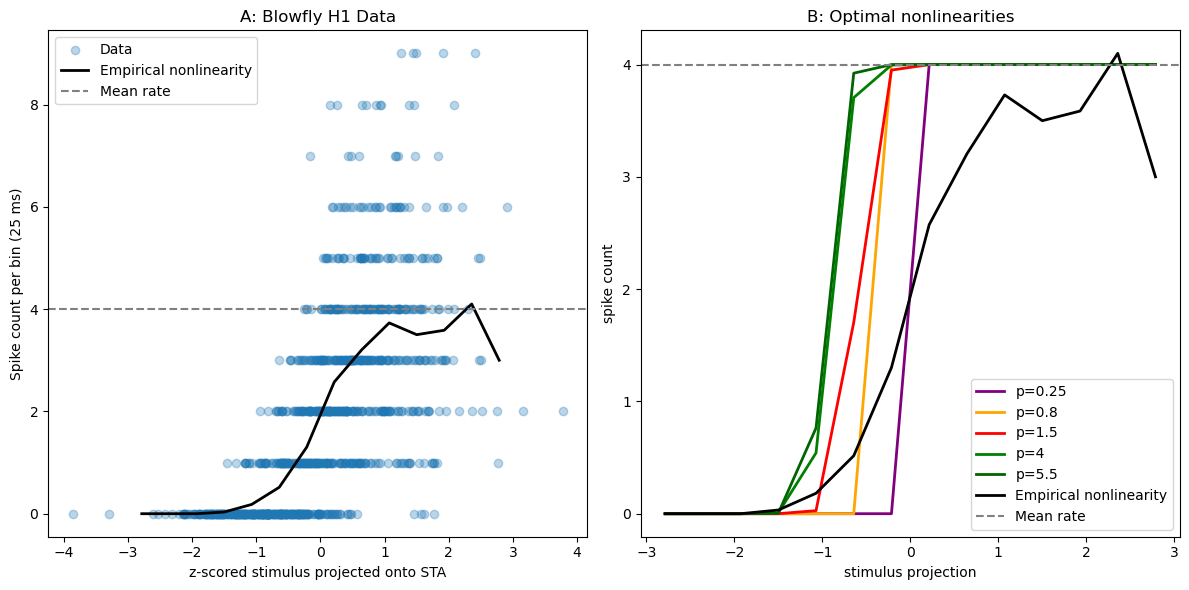

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, poisson

# Step 1: 生成模拟数据
np.random.seed(89)
n_samples = 1000

# 模拟的 z-scored 刺激 (假设已投影到 STA 上)
stimulus = np.random.normal(size=n_samples)

# 经验非线性函数 (empirical nonlinearity)
def empirical_nonlinearity(x):
    return 0.5 * (1 + np.tanh(1.5 * x))

# 生成尖峰数量 (spike count per bin)
mean_rate = 4
spike_counts = poisson.rvs(mu=empirical_nonlinearity(stimulus) * mean_rate)

# Step 2: 拟合经验非线性曲线 (empirical nonlinearity)
bins = np.linspace(-3, 3, 15)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
spike_mean = np.zeros_like(bin_centers)

for i in range(len(bin_centers)):
    bin_idx = (stimulus >= bins[i]) & (stimulus < bins[i+1])
    spike_mean[i] = np.mean(spike_counts[bin_idx])

# Step 3: 绘制图 A
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(stimulus, spike_counts, alpha=0.3, label="Data")
plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity")
plt.axhline(mean_rate, color='gray', linestyle='--', label="Mean rate")
plt.xlabel("z-scored stimulus projected onto STA")
plt.ylabel("Spike count per bin (25 ms)")
plt.title("A: Blowfly H1 Data")
plt.legend()

# Step 4: 绘制不同 p 值下的最优非线性曲线 (图 B)
p_values = [0.25, 0.8, 1.5, 4, 5.5, ]
colors = ['purple', 'orange', 'red', 'green', 'darkgreen']

plt.subplot(1, 2, 2)

for i, p in enumerate(p_values):
    def loss_function(params, x, y, p):
        g_x = 0.5 * (1 + np.tanh(params[0] * x + params[1]))
        return np.sum(np.abs(y - g_x) ** p)

    result = minimize(loss_function, x0=[1.5, 0], args=(stimulus, spike_counts, p), method='Nelder-Mead')
    optimized_params = result.x

    # 最优非线性
    optimized_nonlinearity = 0.5 * (1 + np.tanh(optimized_params[0] * bin_centers + optimized_params[1]))
    
    plt.plot(bin_centers, optimized_nonlinearity * mean_rate, color=colors[i], lw=2, label=f"p={p}")

# 画出经验非线性和 Infomax 曲线
plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity", linestyle='-')
plt.axhline(mean_rate, color='gray', linestyle='--', label="Mean rate")
plt.xlabel("stimulus projection")
plt.ylabel("spike count")
plt.title("B: Optimal nonlinearities")
plt.legend()

plt.tight_layout()
plt.show()


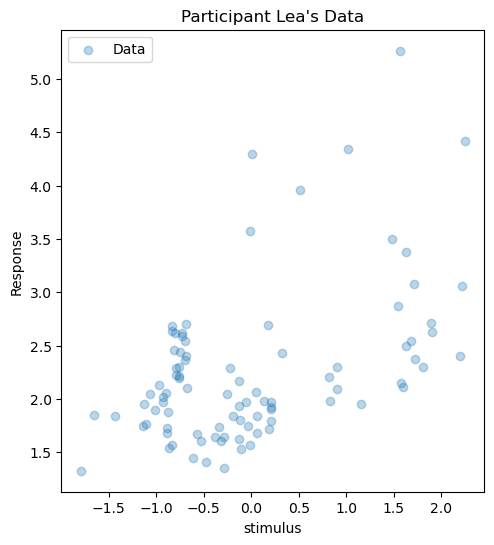

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, poisson

# Select participant data
participant_id = 'Lea'  
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

# Step 1: 标准化刺激和响应数据
stimulus = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
response = participant_gsr_response  # Assume this is analogous to spike counts



plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(stimulus, response, alpha=0.3, label="Data")
plt.xlabel("stimulus")
plt.ylabel("Response")
plt.title("Participant Lea's Data")
plt.legend()


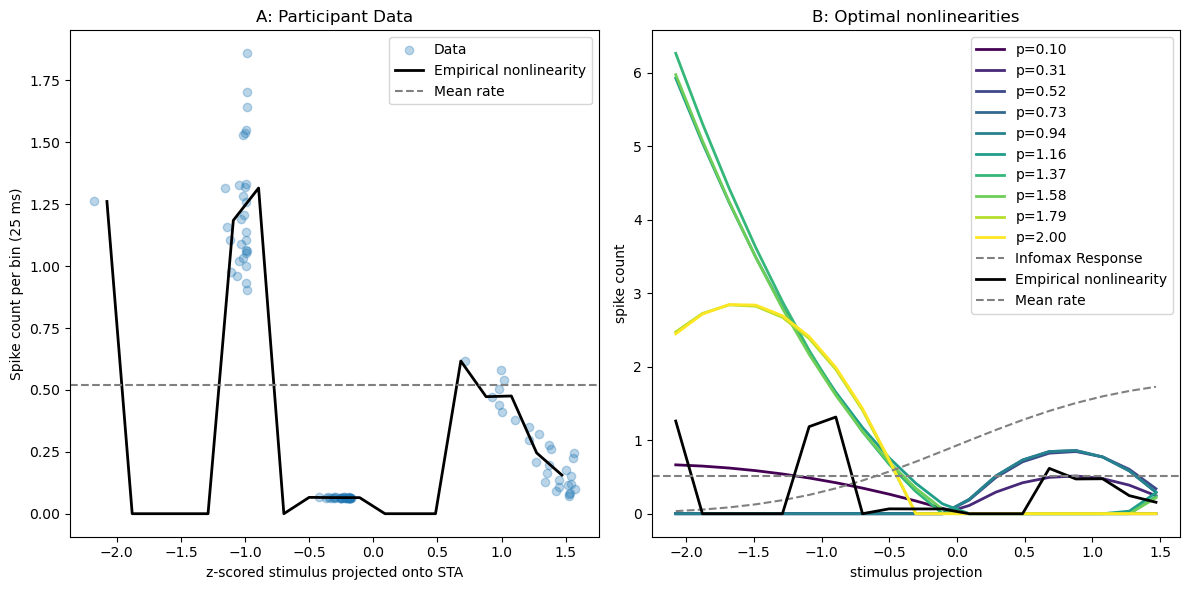

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, poisson

# Select participant data
participant_id = 'Anjela'  
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

# Step 1: 标准化刺激和响应数据
stimulus = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
response = participant_gsr_response  # Assume this is analogous to spike counts

# Step 2: 计算经验非线性曲线
bins = np.linspace(np.min(stimulus), np.max(stimulus), 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
spike_mean = np.zeros_like(bin_centers)

for i in range(len(bin_centers)):
    bin_idx = (stimulus >= bins[i]) & (stimulus < bins[i+1])
    if np.sum(bin_idx) > 0:
        spike_mean[i] = np.mean(response[bin_idx])

# Step 3: 调整惩罚项权重
penalty_weight = 1e-2  # 降低惩罚项权重，使得模型对 p 值变化的敏感性减弱

# Step 4: 定义带平滑项和 x^2 项的带边际放电率约束的损失函数
def constrained_loss_function(params, x, y, p, mean_rate):
    # 加入 x^2 项，参数分别为 params[0], params[1], params[2]
    g_x = np.maximum(0, params[0] * x**2 + params[1] * x + params[2])  # 保证非负
    rate_penalty = np.abs(np.mean(g_x) - mean_rate)  # 约束放电率
    
    # 平滑性惩罚项（通过二阶差分的和来实现）
    curvature_penalty = np.sum(np.diff(g_x, 2) ** 2)
    
    return np.sum(np.abs(y - g_x) ** p) + penalty_weight * rate_penalty + 1e-2 * curvature_penalty  # 增加惩罚项

# Step 5: 绘制不同 p 值下的最优非线性曲线 (图 B)
p_values = np.linspace(0.1, 2, 10)  # 将 p 值从 0.1 到 2 均匀分布
colors = plt.cm.viridis(np.linspace(0, 1, len(p_values)))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(stimulus, response, alpha=0.3, label="Data")
plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity")
plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
plt.xlabel("z-scored stimulus projected onto STA")
plt.ylabel("Spike count per bin (25 ms)")
plt.title("A: Participant Data")
plt.legend()

plt.subplot(1, 2, 2)

mean_rate = np.mean(response)  # 计算当前响应数据的平均放电率

for i, p in enumerate(p_values):
    # 注意：由于我们引入了 x^2 项，所以初始参数变为三个
    result = minimize(constrained_loss_function, x0=[1.0, 1.5, 0], args=(stimulus, response, p, mean_rate), method='Nelder-Mead')
    optimized_params = result.x

    # 最优非线性
    g_x_optimized = np.maximum(0, optimized_params[0] * bin_centers**2 + optimized_params[1] * bin_centers + optimized_params[2])

    plt.plot(bin_centers, g_x_optimized * np.max(response), color=colors[i], lw=2, label=f"p={p:.2f}")

# Step 6: 计算并绘制Infomax曲线
stimulus_cdf = norm.cdf(bin_centers, loc=np.mean(stimulus), scale=np.std(stimulus))
infomax_response = stimulus_cdf * np.max(response)  # 假设最大化信息传输

plt.plot(bin_centers, infomax_response, label="Infomax Response", color='gray', linestyle='--')

# 画出经验非线性
plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity", linestyle='-')
plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
plt.xlabel("stimulus projection")
plt.ylabel("spike count")
plt.title("B: Optimal nonlinearities")
plt.legend()

plt.tight_layout()
plt.show()


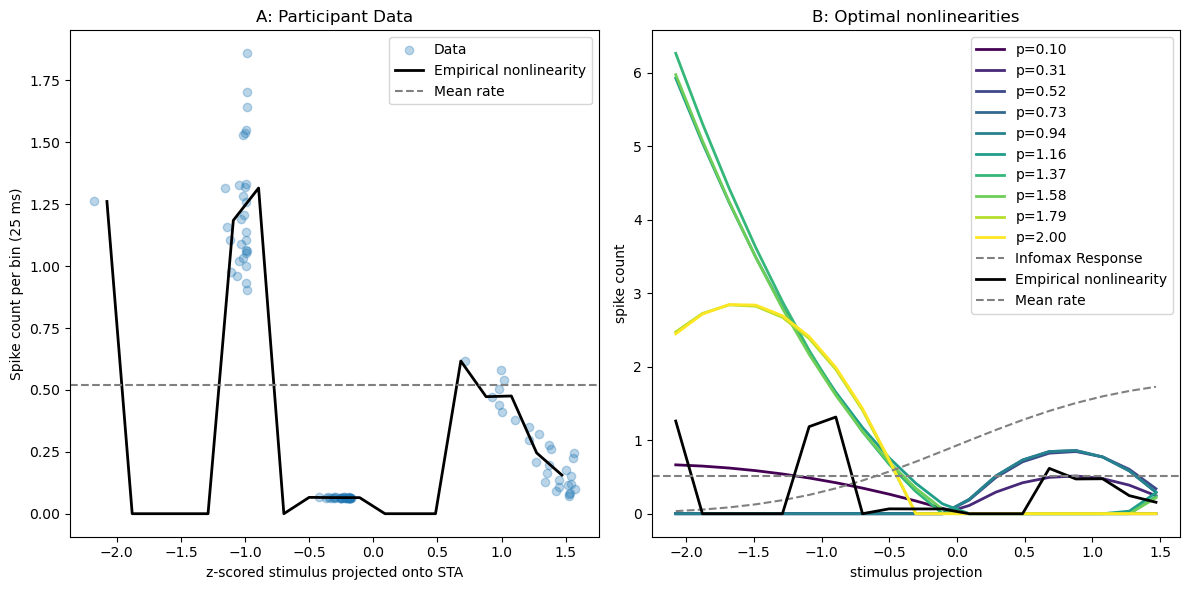

p = 0.10, MSE = 0.3699
p = 0.31, MSE = 0.5321
p = 0.52, MSE = 0.5279
p = 0.73, MSE = 0.5277
p = 0.94, MSE = 0.5277
p = 1.16, MSE = 0.1151
p = 1.37, MSE = 0.1224
p = 1.58, MSE = 0.1167
p = 1.79, MSE = 0.0553
p = 2.00, MSE = 0.0551


In [56]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm, poisson
from scipy.interpolate import interp1d

# Select participant data
participant_id = 'Anjela'  
participant_data = ddf[ddf['Participant'] == participant_id]
participant_speed_contrast = participant_data['Mean Speed'].values
participant_gsr_response = participant_data['Mean GSR'].values

# Step 1: 标准化刺激和响应数据
stimulus = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
response = participant_gsr_response  # Assume this is analogous to spike counts

# Step 2: 计算经验非线性曲线
bins = np.linspace(np.min(stimulus), np.max(stimulus), 20)
bin_centers = 0.5 * (bins[:-1] + bins[1:])
spike_mean = np.zeros_like(bin_centers)

for i in range(len(bin_centers)):
    bin_idx = (stimulus >= bins[i]) & (stimulus < bins[i+1])
    if np.sum(bin_idx) > 0:
        spike_mean[i] = np.mean(response[bin_idx])

# Step 3: 调整惩罚项权重
penalty_weight = 1e-2  # 降低惩罚项权重，使得模型对 p 值变化的敏感性减弱

# Step 4: 定义带平滑项和 x^2 项的带边际放电率约束的损失函数
def constrained_loss_function(params, x, y, p, mean_rate):
    # 加入 x^2 项，参数分别为 params[0], params[1], params[2]
    g_x = np.maximum(0, params[0] * x**2 + params[1] * x + params[2])  # 保证非负
    rate_penalty = np.abs(np.mean(g_x) - mean_rate)  # 约束放电率
    
    # 平滑性惩罚项（通过二阶差分的和来实现）
    curvature_penalty = np.sum(np.diff(g_x, 2) ** 2)
    
    return np.sum(np.abs(y - g_x) ** p) + penalty_weight * rate_penalty + 1e-2 * curvature_penalty  # 增加惩罚项

# Step 5: 绘制不同 p 值下的最优非线性曲线 (图 B)
p_values = np.linspace(0.1, 2, 10)  # 将 p 值从 0.1 到 2 均匀分布
colors = plt.cm.viridis(np.linspace(0, 1, len(p_values)))
mse_values = []  # 存储不同 p 值下的 MSE

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(stimulus, response, alpha=0.3, label="Data")
plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity")
plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
plt.xlabel("z-scored stimulus projected onto STA")
plt.ylabel("Spike count per bin (25 ms)")
plt.title("A: Participant Data")
plt.legend()

plt.subplot(1, 2, 2)

mean_rate = np.mean(response)  # 计算当前响应数据的平均放电率

for i, p in enumerate(p_values):
    # 注意：由于我们引入了 x^2 项，所以初始参数变为三个
    result = minimize(constrained_loss_function, x0=[1.0, 1.5, 0], args=(stimulus, response, p, mean_rate), method='Nelder-Mead')
    optimized_params = result.x

    # 最优非线性
    g_x_optimized = np.maximum(0, optimized_params[0] * bin_centers**2 + optimized_params[1] * bin_centers + optimized_params[2])

    # 插值到 stimulus 的大小
    interp_func = interp1d(bin_centers, g_x_optimized, fill_value="extrapolate")
    g_x_interp = interp_func(stimulus)

    # 计算并存储MSE
    mse = np.mean((response - g_x_interp)**2)
    mse_values.append(mse)

    plt.plot(bin_centers, g_x_optimized * np.max(response), color=colors[i], lw=2, label=f"p={p:.2f}")

# Step 6: 计算并绘制Infomax曲线
stimulus_cdf = norm.cdf(bin_centers, loc=np.mean(stimulus), scale=np.std(stimulus))
infomax_response = stimulus_cdf * np.max(response)  # 假设最大化信息传输

plt.plot(bin_centers, infomax_response, label="Infomax Response", color='gray', linestyle='--')

# 画出经验非线性
plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity", linestyle='-')
plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
plt.xlabel("stimulus projection")
plt.ylabel("spike count")
plt.title("B: Optimal nonlinearities")
plt.legend()

plt.tight_layout()
plt.show()

# 输出每个 p 值对应的 MSE
for p, mse in zip(p_values, mse_values):
    print(f"p = {p:.2f}, MSE = {mse:.4f}")


##### 

In [18]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm
import random

# 确保 LNP 文件夹存在
output_dir = "LNP"
os.makedirs(output_dir, exist_ok=True)

# 预定义一些颜色
color_options = ['purple', 'orange', 'red', 'green', 'darkgreen', 'blue', 'cyan', 'magenta', 'yellow', 'brown', 'pink', 'black', 'lime', 'gray', 'navy']

# 生成 10 个 p 值从 0 到 2 均匀分布
p_values = np.linspace(0, 1.5, 10)

# 为每个参与者选择 10 种颜色
colors = random.sample(color_options, 10)

# 获取所有参与者的名称
participants = ddf['Participant'].unique()

# 对每个参与者执行实验
for participant_id in participants:
    participant_data = ddf[ddf['Participant'] == participant_id]
    participant_speed_contrast = participant_data['Mean Speed'].values
    participant_gsr_response = participant_data['Mean GSR'].values

    # Step 1: 标准化刺激和响应数据
    stimulus = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
    response = participant_gsr_response  # Assume this is analogous to spike counts

    # Step 2: 计算经验非线性曲线
    bins = np.linspace(np.min(stimulus), np.max(stimulus), 25)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    spike_mean = np.zeros_like(bin_centers)

    for i in range(len(bin_centers)):
        bin_idx = (stimulus >= bins[i]) & (stimulus < bins[i+1])
        if np.sum(bin_idx) > 0:
            spike_mean[i] = np.mean(response[bin_idx])

    # Step 3: 调整惩罚项
    penalty_weight = 1e1  # 将惩罚项系数调整为1e1，逐步降低以找到平衡

    # Step 4: 定义带边际放电率约束的损失函数
    def constrained_loss_function(params, x, y, p, mean_rate):
        g_x = np.maximum(0, params[0] * x + params[1])  # 保证非负
        rate_penalty = np.abs(np.mean(g_x) - mean_rate)  # 约束放电率
        return np.sum(np.abs(y - g_x) ** p) + penalty_weight * rate_penalty  # 增加惩罚项

    # Step 5: 绘制不同 p 值下的最优非线性曲线 (图 B)
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(stimulus, response, alpha=0.3, label="Data")
    plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity")
    plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
    plt.xlabel("z-scored stimulus projected onto STA")
    plt.ylabel("Spike count per bin (25 ms)")
    plt.title(f"A: {participant_id} Data")
    plt.legend()

    plt.subplot(1, 2, 2)

    for i, p in enumerate(p_values):
        mean_rate = np.mean(response)  # 计算当前响应数据的平均放电率

        result = minimize(constrained_loss_function, x0=[1.5, 0], args=(stimulus, response, p, mean_rate), method='Nelder-Mead')
        optimized_params = result.x

        # 最优非线性
        optimized_nonlinearity = np.maximum(0, optimized_params[0] * bin_centers + optimized_params[1])

        plt.plot(bin_centers, optimized_nonlinearity * np.max(response), color=colors[i], lw=2, label=f"p={p:.2f}")

    # Step 6: 计算并绘制Infomax曲线
    # 假设Infomax响应是通过stimulus的CDF映射到响应的
    stimulus_cdf = norm.cdf(bin_centers, loc=np.mean(stimulus), scale=np.std(stimulus))
    infomax_response = stimulus_cdf * np.max(response)  # 假设最大化信息传输

    plt.plot(bin_centers, infomax_response, label="Infomax Response", color='gray', linestyle='--')

    # 画出经验非线性
    plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity", linestyle='-')
    plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
    plt.xlabel("stimulus projection")
    plt.ylabel("spike count")
    plt.title(f"B: Optimal nonlinearities for {participant_id}")
    plt.legend()

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(output_dir, f"{participant_id}.png"))
    plt.close()

print(f"All participant plots have been saved to the '{output_dir}' folder.")


All participant plots have been saved to the 'LNP' folder.


# 下面我调整了参数，加入了x^2项，使得对结果的response更加敏感了，activation function relu

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# 确保 LNP 文件夹存在
output_dir = "LNP"
os.makedirs(output_dir, exist_ok=True)

# 获取所有参与者的名称
participants = ddf['Participant'].unique()

# 对每个参与者执行实验
for participant_id in participants:
    participant_data = ddf[ddf['Participant'] == participant_id]
    participant_speed_contrast = participant_data['Mean Speed'].values
    participant_gsr_response = participant_data['Mean GSR'].values

    # Step 1: 标准化刺激和响应数据
    stimulus = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
    response = participant_gsr_response  # Assume this is analogous to spike counts

    # Step 2: 计算经验非线性曲线
    bins = np.linspace(np.min(stimulus), np.max(stimulus), 10)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    spike_mean = np.zeros_like(bin_centers)

    for i in range(len(bin_centers)):
        bin_idx = (stimulus >= bins[i]) & (stimulus < bins[i+1])
        if np.sum(bin_idx) > 0:
            spike_mean[i] = np.mean(response[bin_idx])

    # Step 3: 调整惩罚项权重
    penalty_weight = 1e-1 # 调整惩罚项权重，使得模型对 p 值变化的敏感性减弱

    # Step 4: 定义包含 x, x^2 和 x^3 项的带边际放电率约束的损失函数
    def constrained_loss_function(params, x, y, p, mean_rate):
        # 包含 x, x^2 和 x^3 项
        nonlinear_x = params[0] * x**3 + params[1] * x**2 + params[2] * x + params[3]
        g_x = np.maximum(0, nonlinear_x)  # 使用ReLU激活函数
        rate_penalty = np.abs(np.mean(g_x) - mean_rate)  # 约束放电率
        
        # 平滑性惩罚项（通过二阶差分的和来实现）
        curvature_penalty = np.sum(np.diff(g_x, 2) ** 2)
        
        return np.sum(np.abs(y - g_x) ** p) + penalty_weight * rate_penalty + 1e-2 * curvature_penalty  # 增加惩罚项

    # Step 5: 绘制不同 p 值下的最优非线性曲线 (图 B)
    p_values = np.linspace(0.1, 5, 10)  # 将 p 值从 0.1 到 5 均匀分布
    colors = plt.cm.viridis(np.linspace(0, 1, len(p_values)))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(stimulus, response, alpha=0.3, label="Data")
    plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity")
    plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
    plt.xlabel("z-scored stimulus projected onto STA")
    plt.ylabel("Spike count per bin (25 ms)")
    plt.title(f"A: {participant_id} Data")
    plt.legend()

    plt.subplot(1, 2, 2)

    mean_rate = np.mean(response)  # 计算当前响应数据的平均放电率

    for i, p in enumerate(p_values):
        # 增加一个参数来处理 x^3 项
        result = minimize(constrained_loss_function, x0=[1.0, 1.0, 1.0, 0], args=(stimulus, response, p, mean_rate), method='Nelder-Mead')
        optimized_params = result.x

        # 最优非线性
        nonlinear_x_optimized = optimized_params[0] * bin_centers**3 + optimized_params[1] * bin_centers**2 + optimized_params[2] * bin_centers + optimized_params[3]
        g_x_optimized = np.maximum(0, nonlinear_x_optimized)  # 使用ReLU激活函数

        plt.plot(bin_centers, g_x_optimized * np.max(response), color=colors[i], lw=2, label=f"p={p:.2f}")

    # Step 6: 计算并绘制Infomax曲线
    stimulus_cdf = norm.cdf(bin_centers, loc=np.mean(stimulus), scale=np.std(stimulus))
    infomax_response = stimulus_cdf * np.max(response)  # 假设最大化信息传输

    plt.plot(bin_centers, infomax_response, label="Infomax Response", color='gray', linestyle='--')

    # 画出经验非线性
    plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity", linestyle='-')
    plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
    plt.xlabel("stimulus projection")
    plt.ylabel("spike count")
    plt.title(f"B: Optimal nonlinearities for {participant_id}")
    plt.legend()

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(output_dir, f"{participant_id}.png"))
    plt.close()

print(f"All participant plots have been saved to the '{output_dir}' folder.")


All participant plots have been saved to the 'LNP' folder.


# 这里是给g（x）加了tah（）

In [20]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.stats import norm

# 确保 LNP 文件夹存在
output_dir = "LNP"
os.makedirs(output_dir, exist_ok=True)

# 获取所有参与者的名称
participants = ddf['Participant'].unique()

# 对每个参与者执行实验
for participant_id in participants:
    participant_data = ddf[ddf['Participant'] == participant_id]
    participant_speed_contrast = participant_data['Mean Speed'].values
    participant_gsr_response = participant_data['Mean GSR'].values

    # Step 1: 标准化刺激和响应数据
    stimulus = (participant_speed_contrast - np.mean(participant_speed_contrast)) / np.std(participant_speed_contrast)
    response = participant_gsr_response  # Assume this is analogous to spike counts

    # Step 2: 计算经验非线性曲线
    bins = np.linspace(np.min(stimulus), np.max(stimulus), 10)
    bin_centers = 0.5 * (bins[:-1] + bins[1:])
    spike_mean = np.zeros_like(bin_centers)

    for i in range(len(bin_centers)):
        bin_idx = (stimulus >= bins[i]) & (stimulus < bins[i+1])
        if np.sum(bin_idx) > 0:
            spike_mean[i] = np.mean(response[bin_idx])

    # Step 3: 调整惩罚项权重
    penalty_weight = 1e1 # 降低惩罚项权重，使得模型对 p 值变化的敏感性减弱

    # Step 4: 定义仅包含线性项的带边际放电率约束的损失函数
    def constrained_loss_function(params, x, y, p, mean_rate):
        # 只包含线性项
        linear_x = params[0] * x + params[1]
        g_x = 0.5 * (1 + np.tanh(linear_x))  # 应用于 tanh 函数
        rate_penalty = np.abs(np.mean(g_x) - mean_rate)  # 约束放电率
        
        # 平滑性惩罚项（通过二阶差分的和来实现）
        curvature_penalty = np.sum(np.diff(g_x, 2) ** 2)
        
        return np.sum(np.abs(y - g_x) ** p) + penalty_weight * rate_penalty + 1e-2 * curvature_penalty  # 增加惩罚项

    # Step 5: 绘制不同 p 值下的最优非线性曲线 (图 B)
    p_values = np.linspace(0.1, 5, 10)  # 将 p 值从 0.1 到 2 均匀分布
    colors = plt.cm.viridis(np.linspace(0, 1, len(p_values)))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(stimulus, response, alpha=0.3, label="Data")
    plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity")
    plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
    plt.xlabel("z-scored stimulus projected onto STA")
    plt.ylabel("Spike count per bin (25 ms)")
    plt.title(f"A: {participant_id} Data")
    plt.legend()

    plt.subplot(1, 2, 2)

    mean_rate = np.mean(response)  # 计算当前响应数据的平均放电率

    for i, p in enumerate(p_values):
        # 只包含两个参数 [线性项系数, 偏移项]
        result = minimize(constrained_loss_function, x0=[1.0, 0], args=(stimulus, response, p, mean_rate), method='Nelder-Mead')
        optimized_params = result.x

        # 最优非线性
        linear_x_optimized = optimized_params[0] * bin_centers + optimized_params[1]
        g_x_optimized = 0.5 * (1 + np.tanh(linear_x_optimized))

        plt.plot(bin_centers, g_x_optimized * np.max(response), color=colors[i], lw=2, label=f"p={p:.2f}")

    # Step 6: 计算并绘制Infomax曲线
    stimulus_cdf = norm.cdf(bin_centers, loc=np.mean(stimulus), scale=np.std(stimulus))
    infomax_response = stimulus_cdf * np.max(response)  # 假设最大化信息传输

    plt.plot(bin_centers, infomax_response, label="Infomax Response", color='gray', linestyle='--')

    # 画出经验非线性
    plt.plot(bin_centers, spike_mean, color='black', lw=2, label="Empirical nonlinearity", linestyle='-')
    plt.axhline(np.mean(response), color='gray', linestyle='--', label="Mean rate")
    plt.xlabel("stimulus projection")
    plt.ylabel("spike count")
    plt.title(f"B: Optimal nonlinearities for {participant_id}")
    plt.legend()

    plt.tight_layout()

    # Save the plot
    plt.savefig(os.path.join(output_dir, f"{participant_id}.png"))
    plt.close()

print(f"All participant plots have been saved to the '{output_dir}' folder.")


All participant plots have been saved to the 'LNP' folder.
